In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

2024-01-21 18:48:34.802897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hugo/tensorflow-metal-test/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
#Preprocessing --- Goal to make the data compatible for CNN input
# In tensorflow, we can achieve the same using ImageGenerators

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255.)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255.)

In [3]:
#Pass the images through the generator
trainImageData = train_generator.flow_from_directory("../data/training",
                                                     batch_size=32, #how much images to give per iteration in an epoch
                                                     class_mode="binary", #Incase of multi-class classification, "categorical"
                                                     target_size=(64,64) #Ensures all images are of same size (resizing)
                                                     ) 


testImageData = train_generator.flow_from_directory("../data/testing",
                                                     batch_size=32, #how much images to give per iteration in an epoch
                                                     class_mode="binary", #Incase of multi-class classification, "categorical"
                                                     target_size=(64,64) #Ensures all images are of same size (resizing)
                                                     ) 

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [4]:
#Given dataset is a balanced dataset

trainImageData.class_indices

{'flip': 0, 'notflip': 1}

In [5]:
trainImageData.filenames

['flip/0001_000000010.jpg',
 'flip/0001_000000011.jpg',
 'flip/0001_000000012.jpg',
 'flip/0001_000000013.jpg',
 'flip/0001_000000014.jpg',
 'flip/0001_000000015.jpg',
 'flip/0001_000000016.jpg',
 'flip/0001_000000017.jpg',
 'flip/0001_000000018.jpg',
 'flip/0001_000000019.jpg',
 'flip/0001_000000021.jpg',
 'flip/0001_000000022.jpg',
 'flip/0001_000000023.jpg',
 'flip/0001_000000024.jpg',
 'flip/0001_000000025.jpg',
 'flip/0002_000000009.jpg',
 'flip/0002_000000010.jpg',
 'flip/0002_000000011.jpg',
 'flip/0002_000000014.jpg',
 'flip/0002_000000016.jpg',
 'flip/0002_000000018.jpg',
 'flip/0002_000000019.jpg',
 'flip/0002_000000020.jpg',
 'flip/0002_000000021.jpg',
 'flip/0003_000000001.jpg',
 'flip/0003_000000002.jpg',
 'flip/0003_000000003.jpg',
 'flip/0003_000000004.jpg',
 'flip/0003_000000006.jpg',
 'flip/0003_000000007.jpg',
 'flip/0003_000000009.jpg',
 'flip/0003_000000010.jpg',
 'flip/0003_000000011.jpg',
 'flip/0003_000000012.jpg',
 'flip/0003_000000013.jpg',
 'flip/0003_00000001

In [6]:
trainImageData.image_shape

(64, 64, 3)

In [7]:
# ARchitect the model

model = tf.keras.models.Sequential()

#Convolution Layer
#================================================================================================================================================
#First Convolution Layer

#Conv2D(noFeatureMap, kernelShape, inputShape, activation, padding) Here same means add one pad layer

model.add(tf.keras.layers.Conv2D(32 , (3,3) , input_shape= trainImageData.image_shape , activation= 'relu' , padding='same' )) #Convolve
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) #Pooling

#Second Convolution Layer

#Conv2D(noFeatureMap, kernelShape, inputShape, activation, padding) Here same means add one pad layer

model.add(tf.keras.layers.Conv2D(16 , (3,3), activation= 'relu' , padding='same' )) #Convolve
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) #Pooling

#=================================================================================================================================================
# Flatten

model.add(tf.keras.layers.Flatten())

#=================================================================================================================================================
# ANN
model.add(tf.keras.layers.Dense(units= 4096 , activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units= 1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units= 256, activation="relu"))
model.add(tf.keras.layers.Dense(units= 1 , activation="sigmoid"))
#model.add(tf.keras.layers.Dense(units= 2 , activation="softmax"))

2024-01-21 18:48:38.003083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-21 18:48:38.003310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 4096)              1

In [9]:
#Compile

model.compile(optimizer="adam",
              loss="binary_crossentropy", #For multi-class classification: categorical_crossentropy | sparse_categorical_crossentropy
              metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.5)])

In [10]:
len(trainImageData.filenames) // trainImageData.batch_size

74

In [11]:
# Fit the model

model.fit(trainImageData,
          validation_data=testImageData,
          epochs=10,
          steps_per_epoch = len(trainImageData.filenames) // trainImageData.batch_size,
          validation_steps= len(testImageData.filenames) // testImageData.batch_size)

Epoch 1/10


2024-01-21 18:48:38.895449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-21 18:48:39.526687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-21 18:48:39.597864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


74/74 [==============================] - ETA: 0s - loss: 0.9265 - f1_score: 0.5710

2024-01-21 18:49:08.849352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-21 18:49:08.918089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 37s 488ms/step - loss: 0.9265 - f1_score: 0.5710 - val_loss: 0.6716 - val_f1_score: 0.5244
Epoch 2/10
74/74 [==============================] - 37s 499ms/step - loss: 0.6247 - f1_score: 0.6750 - val_loss: 0.5037 - val_f1_score: 0.7327
Epoch 3/10
74/74 [==============================] - 38s 509ms/step - loss: 0.4839 - f1_score: 0.7691 - val_loss: 0.4399 - val_f1_score: 0.7617
Epoch 4/10
74/74 [==============================] - 38s 510ms/step - loss: 0.3281 - f1_score: 0.8619 - val_loss: 0.2700 - val_f1_score: 0.9068
Epoch 5/10
74/74 [==============================] - 38s 516ms/step - loss: 0.2460 - f1_score: 0.8960 - val_loss: 0.1556 - val_f1_score: 0.9597
Epoch 6/10
74/74 [==============================] - 37s 505ms/step - loss: 0.1723 - f1_score: 0.9334 - val_loss: 0.1328 - val_f1_score: 0.9548
Epoch 7/10
74/74 [==============================] - 37s 507ms/step - loss: 0.1469 - f1_score: 0.9381 - val_loss: 0.1724 - val_f1_score: 0.9158
Epoch 8/10

In [14]:
model.save('monReader.keras_tf')
#model.save('monReader.keras_tf', save_format='tf')

2024-01-21 19:13:33.919774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4096]
	 [[{{node inputs}}]]
2024-01-21 19:13:33.925763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-21 19:13:34.036805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4096]
	 [[{{node inputs}}]]
2024-01-21 19

INFO:tensorflow:Assets written to: monReader.keras_tf/assets


INFO:tensorflow:Assets written to: monReader.keras_tf/assets


## Deployment of the model

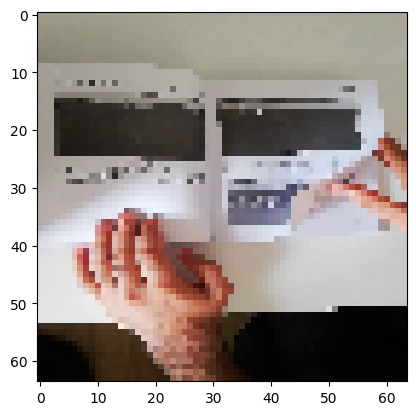

In [15]:
imageToPredict = tf.keras.preprocessing.image.load_img('../data/testing/flip/0006_000000008.jpg', target_size=(64,64))
plt.imshow(imageToPredict)

In [16]:
#Step2: Convert image to np array 
myImageNPArray = tf.keras.preprocessing.image.img_to_array(imageToPredict)
myImageNPArray.shape

(64, 64, 3)

In [17]:
# Step3: Make the image compatible for the model by adding n
myCompatibleImage = np.expand_dims(myImageNPArray, axis = 0)
myCompatibleImage.shape

(1, 64, 64, 3)

In [18]:
#Step4: Prediction
prediction = model.predict(myCompatibleImage)

2024-01-15 22:43:05.271129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 480ms/step


In [19]:
print(prediction)

[[0.]]


### The model is good, but it is 255MB, so it will NOT fit in a smartphone app! 